In [1]:
import os
import sys
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk
import json

%matplotlib inline

/Users/luke/opt/miniconda3/envs/exofit/lib/python3.10/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Download and load in all TESS LCs

In [2]:
# Function to wrap around juliet's get_TESS_data function to deal with multiple TESS sectors
def juliet_get_tess_data(lkf):
    for indf,thisf in enumerate(lkf):
        thist,thisf,thisferr = juliet.get_TESS_data(thisf)
        if indf == 0:
            t,f,ferr = thist,thisf,thisferr
        else:
            t,f,ferr = np.concatenate((t,thist)), np.concatenate((f,thisf)), \
                np.concatenate((ferr,thisferr))
    
    return t,f,ferr

In [3]:
# Basic constants
tesst0 = 2457000.0  # BJD offset for TESS timestamps

p1 = 3.37923577236328  # period in days
perr1 = .0001425314  # error on period in days
tc1 = 2459420.207144  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0018298243  # transit midpoint in days

In [4]:
# Print out needed t0 and mdilution_TESS and its prior width.
tc1 -= tesst0
print(tc1)
# print(1.0-contr)
# print(contr*0.1)

# crude estimate on translated Rp/R* fractional error 
# if too small, fix mdilution_TESS to 1.0
# print(np.sqrt(contr*0.1)) 

2420.207144000102


In [5]:
# download the lightcurve using lightkurve
# Make sure to change the my_dir to the download folder you want!
my_dir = './'
lkfile = lk.search.search_lightcurvefile('TOI 4439', mission='TESS')
lkf = lkfile.download_all(download_dir=my_dir)

In [6]:
# juliet needs the fits file
lkf = glob.glob(os.path.join(my_dir, 'mastDownload/*/*/tess*.fits'))
lkf.sort()
lkf = lkf[0:1]

In [7]:
t,f,ferr = juliet_get_tess_data(lkf)

(2390.6553572621588, 2418.8555394658906)

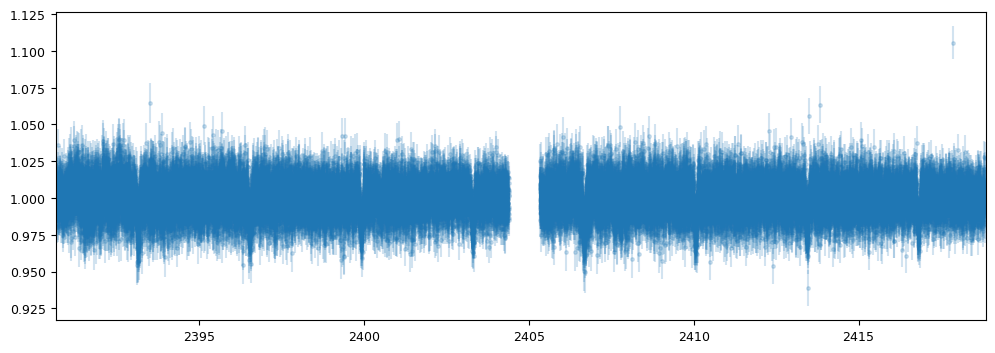

In [8]:
# Put data arrays into dictionaries so we can fit it with juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t,f,ferr

# Plot data:
plt.figure(figsize=(12,4))
plt.errorbar(t,f, yerr=ferr, fmt='.',alpha=0.2)
plt.xlim([np.min(t),np.max(t)])

## Detrending

In [9]:
# First, block out the transits
# Get phases --- identify out-of-transit (oot) times by phasing the data
# and selecting all points at absolute phases larger than 0.02:
phases = juliet.utils.get_phases(t, p1, tc1)
idx_oot = np.where(np.abs(phases)>0.02)[0]
# Save the out-of-transit data into dictionaries so we can feed them to juliet:
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot],f[idx_oot],ferr[idx_oot]

In [10]:
# Perform the juliet fit. Load dataset first (note the GP regressor will be the times):
dataset = juliet.load(priors='./detrending/priors.txt', t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, GP_regressors_lc = times, \
                      out_folder = './detrending/')

In [11]:
results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./detrending/_dynesty_NS_posteriors.pkl


(2390.6553572621588, 2418.8555394658906)

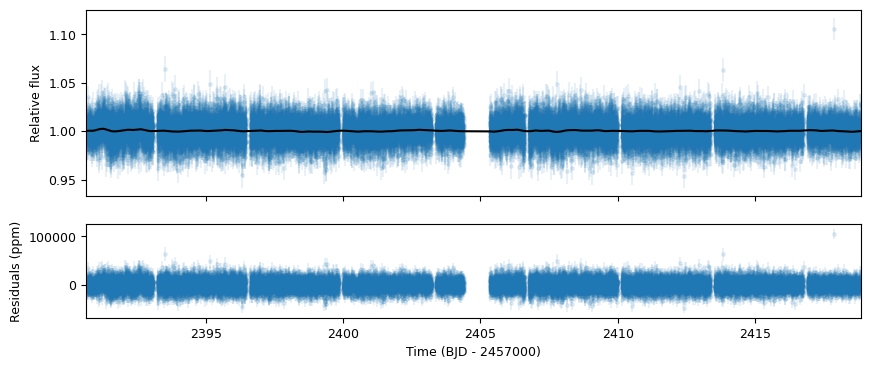

In [12]:
# Get model to visually check
model_fit = results.lc.evaluate('TESS')

# Plot:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])

# First the data and the model on top:
ax1 = plt.subplot(gs[0])
ax1.errorbar(times['TESS'], fluxes['TESS'], fluxes_error['TESS'],fmt='.',alpha=0.1)
ax1.plot(times['TESS'], model_fit, color='black', zorder=100)
ax1.set_ylabel('Relative flux')
ax1.set_xlim(np.min(times['TESS']),np.max(times['TESS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Now the residuals:
ax2 = plt.subplot(gs[1])
ax2.errorbar(times['TESS'], (fluxes['TESS']-model_fit)*1e6, \
             fluxes_error['TESS']*1e6,fmt='.',alpha=0.1)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD - 2457000)')
ax2.set_xlim(np.min(times['TESS']),np.max(times['TESS']))

In [13]:
# Get juliet model prediction for the full lightcurve:
model_prediction = results.lc.evaluate('TESS', t = t, GPregressors = t)
# this is the general trend you want to remove from the TESS light curve

# Repopulate dictionaries with new detrended flux:
# Think about how you want to detrend the light curve, and scale the errors in flux as well
# times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t[idx_oot], (f/model_prediction)[idx_oot], \
#             (ferr/model_prediction)[idx_oot]
times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, f/model_prediction, ferr/model_prediction

In [14]:
print(float('nan') in fluxes['TESS'])
print(float('nan') in fluxes_error['TESS'])

False
False


## Transit Fit

In [15]:
dataset = juliet.load(priors='./transit_fit_4439_TESS/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = './transit_fit_4439_TESS/')

In [16]:
results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.
Detected dynesty sampler output files --- extracting from ./transit_fit_4439_TESS/_dynesty_NS_posteriors.pkl


Text(0.5, 0, 'Phases')

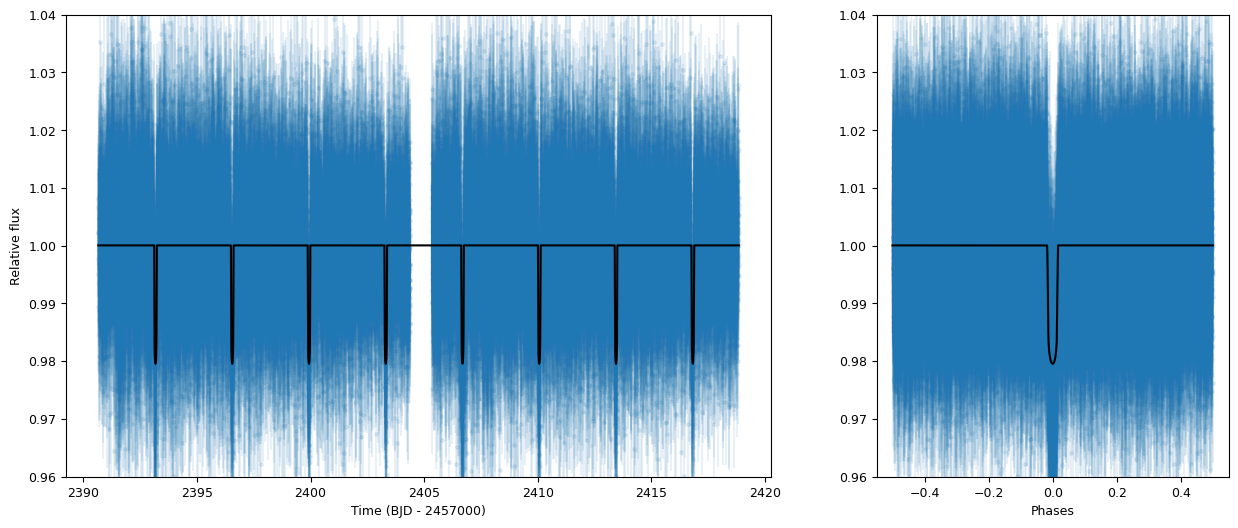

In [17]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], 
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model, color='black',zorder=10)

# ax1.set_xlim([2403.2,2403.7])
ax1.set_ylim([0.96,1.04])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'],
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
# ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.96,1.04])
ax2.set_xlabel('Phases')

## Save Fit Lightcurve

In [18]:
results_file = 'fit_results.json'
try:
    with open(results_file, 'r') as f:
        results = json.load(f)
except:
    results = {} # dictionary to record the test results
    
results['TESS'] = {
    'times_lc':dataset.times_lc['TESS'].tolist(), 
    'data_lc':dataset.data_lc['TESS'].tolist(), 
    'errors_lc':dataset.errors_lc['TESS'].tolist(), 
    'transit_model':transit_model.tolist(), 'phases':phases.tolist(), 'idx':idx.tolist()
    }

with open(results_file, 'w') as f:
    json.dump(results, f)